## EXPERIMENT 1: MagFace

In [1]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from DET_utils.DET_plots import *
from DET_utils.DET import *

from IPython import embed


### MagFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

### Load data

In [6]:
feature_list_children = '../../data/data_full/feature_vectors/adaface_feature_vectors/similarity_scores_children_full_baseline1.pt'
# feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/feat_img_children_full.list'


image_names_c, ids_c, num_ids_c, norm_feats_c = load_adaface_vectors(feature_list_children)
image_names_a, ids_a, num_ids_a, norm_feats_a = load_adaface_vectors(feature_list_children)
ids_a = ["_".join(x.split("_")[1:]) for x in ids_a]


# Similarity matrices from adaface - all
sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)

# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_canonical_df_BIBLE.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]


In [7]:
her = 584
print(image_names_c[her], ids_c[her], num_ids_c[her])
print(image_names_a[her], ids_a[her], num_ids_a[her])

African_265_0 African_265 169
African_265_0 265 169


### GET METRICS 10 TIMES

In [8]:
def balance_child_data_can(y_df, print_stats=False, random_state=42):
    """
    Input: raw df for ylfw and rfw
    Returns: csvs with equally balanced children and adults
    Original child_balanced has random state 42
    """

    # Randomly sample 1000 identities from the entire dataset
    ylfw_witha_balanced = y_df.sample(n=2000, random_state=random_state)

    if print_stats:
        # Print the distribution of age groups and other relevant statistics
        print("Balanced data?:", ylfw_witha_balanced.children_agegroup.value_counts())

    return ylfw_witha_balanced


In [9]:
random_states = [1,2,3,4,5,6,7,8,9,10]
sim_mat_dict_all_magface_ex1_1 = {}
FNIR_c_list=[]
FNIR_a_list=[]
FPIR_c_list=[]
FPIR_a_list=[]
FPD_list=[]
FND_list=[]
GARBE_list=[]

for random_state_i in random_states:

    ### Load children and adults balanced data ###
    children_balanced_df_i = balance_child_data_can(children_all, print_stats=False, random_state=random_state_i)
    adults_balanced_df_i = balance_child_data(adults_all, print_stats=False, random_state=random_state_i)


    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)


    ### All reference image names, enrolled and non-enrolled image names - adults ###
    a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
    non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
    all_reference_image_names_a = list(adults_balanced_df_i.image_name)



    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a]



    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]


    sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]

    # Extract corresponding rows from the numerical ids
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_a_reference = num_ids_a[indices_a_all_reference]


    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a]


    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled_0 = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_a_non_enrolled_0 = sim_mat_a_reference_cols[indices_a_non_enrolled]

    # Extract corresponding rows from the numerical ids
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]


    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled_0 = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_a_enrolled_0 = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

    # Extract corresponding rows from the numerical ids
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_a_enrolled = num_ids_a[indices_a_enrolled]


    ### DET THINGS ###

    thold = (np.percentile(sim_mat_c,90)+np.percentile(sim_mat_a,90))/2
    # thold = np.percentile(sim_mat_a, 99)

    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled_0, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)
    FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled_0, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=thold)
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled_0, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_a = compute_fpir(sim_mat_a_non_enrolled_0, num_ids_a_non_enrolled, num_ids_a_reference, thold=thold)




    # OBS maybe compute Garbe outside funtion to choose a good alpha?
    alpha_garbe = 0.25
    FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)


    FNIR_c_list.append(FNIR_c)
    FNIR_a_list.append(FNIR_a)
    FPIR_c_list.append(FPIR_c)
    FPIR_a_list.append(FPIR_a)
    FPD_list.append(FPD_i)
    FND_list.append(FND_i)
    GARBE_list.append(GARBE_i)

    sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_c_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_a_enrolled
    sim_mat_dict_all_magface_ex1_1['sim_mat_c_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_c_non_enrolled_0)
    sim_mat_dict_all_magface_ex1_1['sim_mat_a_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_a_non_enrolled_0)


    print("done")

# Create a DataFrame from the lists
data = {'Iteration': random_states,'FNIR_can': FNIR_c_list, 'FNIR_mix': FNIR_a_list, "FPIR_can": FPIR_c_list, "FPIR_mix": FPIR_a_list, "FPD": FPD_list, "FND": FND_list, "GARBE": GARBE_list, "Threshold": thold}
df_all_results = pd.DataFrame(data)


NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 624 106
NOT SAME LENGTH 

In [20]:
df_all_results

,Iteration,FNIR_can,FNIR_mix,FPIR_can,FPIR_mix,FPD,FND,GARBE,Threshold
0,1,0.017955,0.094756,1.000000,0.998069,0.008564,0.340701,0.257667,0.363786
1,2,0.014798,0.082072,1.000000,0.998056,0.010032,0.347244,0.262941,0.363786
2,3,0.017054,0.075881,1.000000,0.997992,0.010803,0.316493,0.240070,0.363786
3,4,0.014096,0.089383,0.998617,0.999006,0.001880,0.363783,0.273307,0.363786
4,5,0.019520,0.097248,1.000000,0.999029,0.004157,0.332834,0.250665,0.363786
5,6,0.019969,0.088463,0.994269,1.000000,0.026425,0.315837,0.243484,0.363786
6,7,0.019562,0.082840,1.000000,1.000000,0.000000,0.308970,0.231728,0.363786
7,8,0.010196,0.088747,0.995862,0.997070,0.006106,0.396950,0.299239,0.363786
8,9,0.024623,0.080869,0.997301,0.999044,0.008261,0.266590,0.202008,0.363786
9,10,0.013751,0.083144,0.997106,0.998018,0.004707,0.358084,0.269740,0.363786


In [21]:
df_all_results.describe()

,Iteration,FNIR_can,FNIR_mix,FPIR_can,FPIR_mix,FPD,FND,GARBE,Threshold
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,0.017152,0.086340,0.998315,0.998629,0.008094,0.334749,0.253085,0.363786
std,3.02765,0.004091,0.006578,0.002086,0.000948,0.007321,0.035672,0.026388,0.000000
min,1.00000,0.010196,0.075881,0.994269,0.997070,0.000000,0.266590,0.202008,0.363786
25%,3.25000,0.014271,0.082264,0.997154,0.998027,0.004295,0.316001,0.240924,0.363786
50%,5.50000,0.017504,0.085804,0.999308,0.998538,0.007184,0.336768,0.254166,0.363786
75%,7.75000,0.019551,0.089224,1.000000,0.999040,0.009665,0.355374,0.268040,0.363786
max,10.00000,0.024623,0.097248,1.000000,1.000000,0.026425,0.396950,0.299239,0.363786


### Results
The FNIR values for both groups are relatively close to each other, with FNIR_c ranging from approximately 0.338 to 0.377 and FNIR_a ranging from approximately 0.277 to 0.310.


Larger variation in the FPIR. 

# ting til udnersøgelse af sim scores og OFIQ

In [ ]:
sim_mat_a_enrolled_0_df = pd.DataFrame(sim_mat_a_enrolled_0, columns = enrolled_image_names_a, index=enrolled_image_names_a)

In [ ]:
sim_mat_a_enrolled_0_df_backup = sim_mat_a_enrolled_0_df.copy()

In [ ]:
import pandas as pd

# Assuming sim_mat_a_enrolled_0_df is your DataFrame
# Extract the identity names from the index and columns
identity_rows = sim_mat_a_enrolled_0_df.index.str.extract(r'(.*?_0{3})')[0]
identity_cols = sim_mat_a_enrolled_0_df.columns.str.extract(r'(.*?_0{3})')[0]

# Map the extracted identities back to the DataFrame's rows and columns
sim_mat_a_enrolled_0_df.index = identity_rows
sim_mat_a_enrolled_0_df.columns = identity_cols


In [ ]:
sim_mat_a_enrolled_0_df.head()

In [ ]:

# Replace values of 1 with NaN for accurate mean calculation
filtered_df = sim_mat_a_enrolled_0_df.replace(1, pd.NA)
filtered_df.head()

In [ ]:
# unique column names
uniq_names = np.unique(identity_cols)

In [ ]:
# take out the subset of the df

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# for j in range(1,100):
#     print(j)
#     udtræk = sim_mat_a_enrolled_0_df.loc[uniq_names[j], uniq_names[j]]
#     print(udtræk)

In [ ]:
j=8
udtræk = sim_mat_a_enrolled_0_df.loc[uniq_names[j], uniq_names[j]]
print(udtræk)

In [ ]:
udtræk = sim_mat_a_enrolled_0_df.loc['m.0126y2_000', 'm.0126y2_000']
udtræk

In [ ]:
# show top three
top3_val = sim_mat_a_enrolled_0_df_backup['m.01bsgq_0001'].nlargest(4)
top3_val

## Load OFIQ

In [ ]:
df_a_ofiq = pd.read_csv("/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/data/OFIQ_results/table_adults_all_in_one.csv", sep=";")


def extract_identifier(filepath):
    filename = filepath.split('/')[-1]
    parts = filename.split('.')
    if parts[-2].isdigit():
        identifier = '.'.join(parts[-3:-1])
    else:
        identifier = '.'.join(parts[:-1])  # Join everything except the extension
    return identifier

df_a_ofiq['Identityname'] = df_a_ofiq['Filename'].apply(extract_identifier)
df_a_ofiq['Identityname'] = df_a_ofiq['Identityname'].str[:-5]


In [ ]:

# Group by the new indices and columns, and then calculate the mean
grouped_by_rows = filtered_df.groupby(filtered_df.index).mean().mean(axis=1)
grouped_by_cols = filtered_df.groupby(filtered_df.columns, axis=1).mean().mean()

# Combine the means from rows and columns
final_mean_scores = (grouped_by_rows + grouped_by_cols)

print(final_mean_scores)


In [ ]:
df_all_results

In [ ]:
print(sim_mat_a_enrolled_0, sim_mat_a_enrolled)

In [ ]:
print(sim_mat_a_enrolled_0.shape, sim_mat_a_enrolled.shape)

#### Check enrolled and non-enrolled similarity distributions

# From DET utils - check import

In [22]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [25]:
mated_scores1 = sim_mat_c_enrolled

nonmated_scores1 = remove_ones(sim_mat_c_non_enrolled_0)
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,10610.000000,1.381309e+06
1,Minimum,0.078514,-3.301184e-01
2,Maximum,0.996554,9.289597e-01
3,Mean,0.649424,1.799716e-01
4,St. Dev.,0.143286,1.376966e-01
5,Skewness,-0.531307,2.738996e-01
6,Ex. Kurtosis,0.179565,1.116988e-01


In [26]:
mated_scores2 = sim_mat_a_enrolled
nonmated_scores2 = remove_ones(sim_mat_a_non_enrolled_0)
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,14822.000000,3.237881e+06
1,Minimum,-0.032878,-3.634797e-01
2,Maximum,0.996554,8.740541e-01
3,Mean,0.620838,1.723239e-01
4,St. Dev.,0.149347,1.325363e-01
5,Skewness,-0.480368,2.442105e-01
6,Ex. Kurtosis,0.183904,2.009357e-02


In [27]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [28]:
def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)
    plt.figure(figsize=figure_size)
    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='green', alpha=0.5, label=nonmated_label)
        xlabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color='red', alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color='green', alpha=0.5, label=nonmated_label)
        xlabel = "Count"
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(xlabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)

    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()

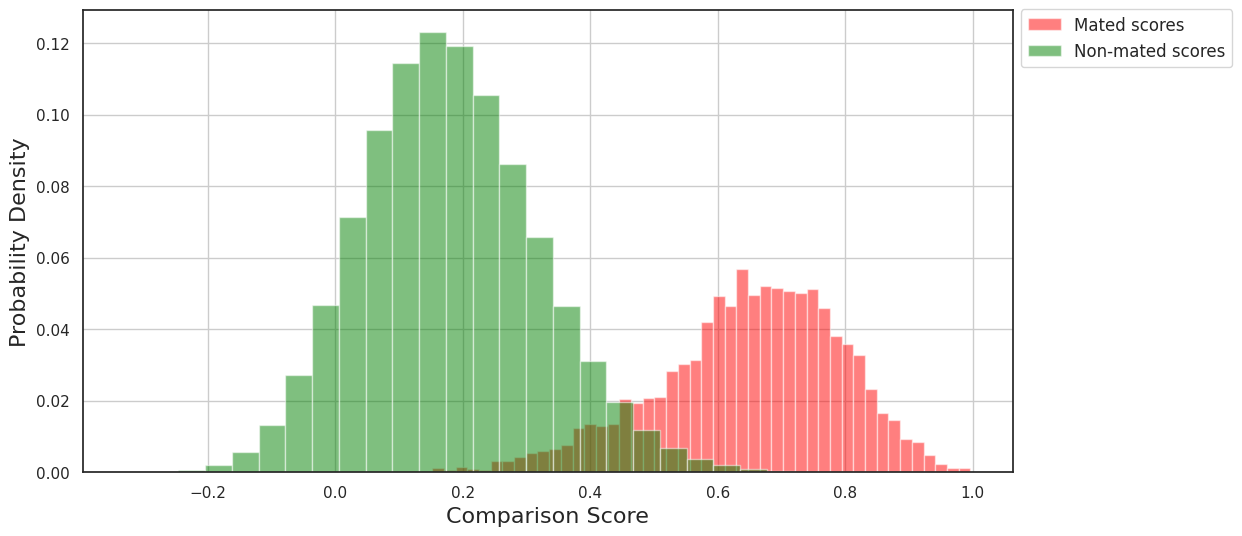

In [29]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True)


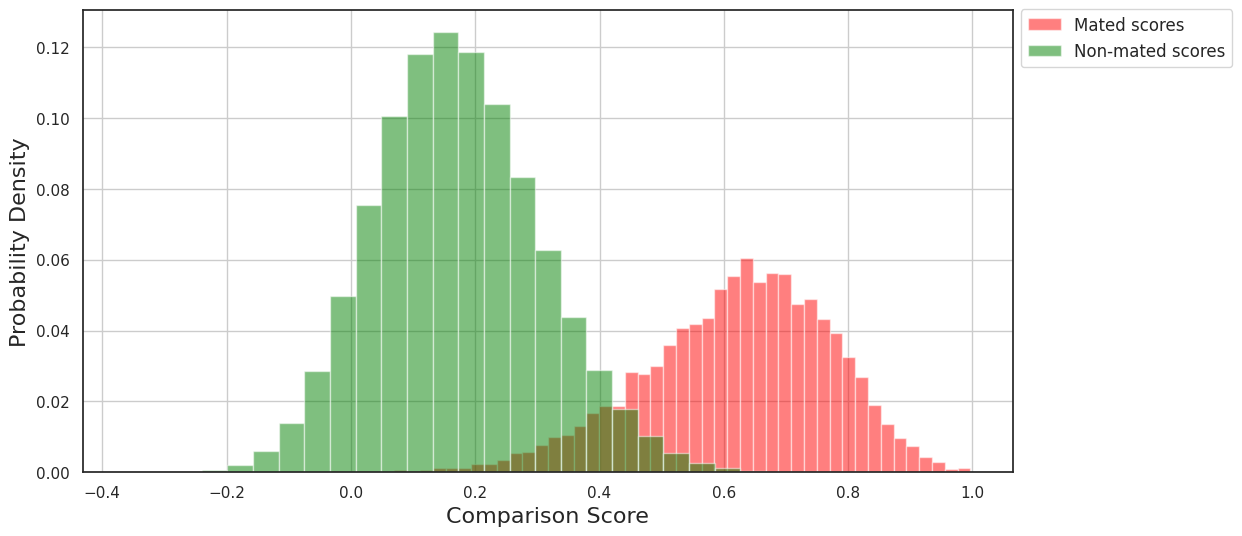

In [30]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True)


In [ ]:
df_canonical = pd.read_csv("../../data/OFIQ_results/canonical_children_final.csv", sep=";")

In [ ]:
image_names_can, ids_can, num_ids_can, norm_feats_can = load_magface_vectors(feature_list_children, canonical=True, df_c_can=df_canonical)
# Similarity matrices from magface - canonical
sim_mat_canonical = np.dot(norm_feats_can, norm_feats_can.T)

In [ ]:
random_states = [3]#[1,2,3,4,5,6,7,8,9,10]
sim_mat_dict_all_magface_ex1_2 = {}
FNIR_c_list=[]
FNIR_can_list=[]
FPIR_c_list=[]
FPIR_can_list=[]


for random_state_i in random_states:

    ### Load children and canonical balanced data ###
    children_balanced_df_i = balance_child_data(children_all, print_stats=False, random_state=random_state_i)
    canonical_names = list(df_canonical.Filename.apply(lambda x: x[:-4]))
    canonical_children_balanced_df_i = children_balanced_df_i[children_balanced_df_i.image_name.isin(canonical_names)]

    ### All reference image names, enrolled and non-enrolled image names - children ###
    c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
    non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
    all_reference_image_names_c = list(children_balanced_df_i.image_name)


    ### All reference image names, enrolled and non-enrolled image names - canonical ###
    can_mates = canonical_children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
    enrolled_identity_names_can = can_mates[can_mates[('identity_name', 'count')] > 1].index
    enrolled_image_names_can = list(canonical_children_balanced_df_i[canonical_children_balanced_df_i["identity_name"].isin(enrolled_identity_names_can)].image_name)
    non_enrolled_identity_names_can = can_mates[can_mates[('identity_name', 'count')] == 1].index
    non_enrolled_image_names_can = list(canonical_children_balanced_df_i[canonical_children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_can)].image_name)
    all_reference_image_names_can = list(canonical_children_balanced_df_i.image_name)


    ### Similarity matrices for ids in reference database ###
    indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c]
    indices_can_all_reference = [image_names_can.index(name) for name in all_reference_image_names_can]

    # Extract corresponding columns from the similarity matrix
    sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]
    sim_mat_can_reference_cols = sim_mat_canonical[:, indices_can_all_reference]

    # Extract corresponding rows from the numerical ids
    num_ids_c_reference = num_ids_c[indices_c_all_reference]
    num_ids_can_reference = num_ids_can[indices_can_all_reference]


    ### Similarity matrices for non-enrolled ids ###
    # Get indices of all feature and numerical id elements that are non-enrolled  ids
    indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c]
    indices_can_non_enrolled = [image_names_can.index(name) for name in non_enrolled_image_names_can]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_non_enrolled = sim_mat_c_reference_cols[indices_c_non_enrolled]
    sim_mat_can_non_enrolled = sim_mat_can_reference_cols[indices_can_non_enrolled]

    # Extract corresponding rows from the numerical ids
    num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
    num_ids_can_non_enrolled = num_ids_can[indices_can_non_enrolled]

    ### Similarity matrices for enrolled ids ###
    # Get indices of all feature and numerical id elements that are enrolled ids
    indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c]
    indices_can_enrolled = [image_names_can.index(name) for name in enrolled_image_names_can]

    # Extract corresponding rows from the similarity matrix
    sim_mat_c_enrolled = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)] # only enrolled columns and rows
    sim_mat_can_enrolled = sim_mat_a[np.ix_(indices_can_enrolled, indices_can_enrolled)]

    # Extract corresponding rows from the numerical ids
    num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
    num_ids_can_enrolled = num_ids_can[indices_can_enrolled]


    ### DET THINGS ###
    thold = 0.43

    ### Evaluation metrics ###
    # FNIR
    FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)
    FNIR_can, sim_mat_can_enrolled = compute_fnir(sim_mat_can_enrolled, sim_mat_canonical, enrolled_identity_names_can, num_ids_can_enrolled, ids_can, thold=thold)
    # FPIR
    FPIR_c = compute_fpir(sim_mat_c_non_enrolled, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
    FPIR_can = compute_fpir(sim_mat_can_non_enrolled, num_ids_can_non_enrolled, num_ids_can_reference, thold=thold)


    FNIR_c_list.append(FNIR_c)
    FNIR_can_list.append(FNIR_can)
    FPIR_c_list.append(FPIR_c)
    FPIR_can_list.append(FPIR_can)

    sim_mat_dict_all_magface_ex1_2['sim_mat_c_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_c_enrolled
    sim_mat_dict_all_magface_ex1_2['sim_mat_can_enrolled_iteration_{}'.format(random_state_i)]=sim_mat_can_enrolled
    sim_mat_dict_all_magface_ex1_2['sim_mat_c_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_c_non_enrolled)
    sim_mat_dict_all_magface_ex1_2['sim_mat_can_non_enrolled_iteration_{}'.format(random_state_i)]=remove_ones(sim_mat_can_non_enrolled)


    print("done")

# Create a DataFrame from the lists
data_can = {'Iteration': random_states,'FNIR_c': FNIR_c_list, 'FNIR_can': FNIR_can_list, "FPIR_c": FPIR_c_list, "FPIR_can": FPIR_can_list, "Threshold": thold}
df_can_results = pd.DataFrame(data_can)


In [ ]:
df_can_results